In [17]:
import json
import random as python_random

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import tensorflow as tf
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import OneHotEncoder, minmax_scale, normalize

from astronet.constants import ASTRONET_WORKING_DIRECTORY as asnwd
from astronet.constants import (
    PLASTICC_CLASS_MAPPING,
    LSST_FILTER_MAP,
    LSST_PB_COLORS as pb_colors,
)
from astronet.t2.model import T2Model
from astronet.utils import find_optimal_batch_size

tf.get_logger().setLevel("ERROR")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

np.set_printoptions(precision=15)
pd.options.display.float_format = "{:.15f}".format

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(RANDOM_SEED)

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.serif": ["Computer Modern Roman"],
    }
)

plt.rcParams["figure.figsize"] = (20, 3)
mpl.rc("axes", labelsize=22)
mpl.rc("xtick", labelsize=28)
mpl.rc("ytick", labelsize=28)
mpl.style.use("seaborn-whitegrid")

print(plt.style.available)

architecture = "t2"
dataset = "plasticc"

# Load and process data
cdf = pl.read_csv(f"{asnwd}/data/plasticc/kaggle/plasticc_train_lightcurves.csv")
cdf = (
    cdf.rename(
        {"passband": "filter", "flux_err": "flux_error", "detected_bool": "detected"}
    )
    .with_columns(pl.col("filter").map_dict(LSST_FILTER_MAP))
    .filter(pl.col("detected") == True)
)

# cdf = cdf.pivot(
#     index=["mjd", "object_id"], values=["flux", "flux_error"], columns="filter"
# )

df = pl.read_parquet(f"{asnwd}/data/plasticc/kaggle/gps.parquet")

# Do filtering on class here
# df = df.filter(pl.col("target") == "SNIa")

num_classes = df.select("target").n_unique()

X_test = df.select("^lsst.*$").to_numpy().reshape((df.height // 100), 100, 6)
Z_test = (
    df.select("^hostgal_.*$")
    .to_numpy()
    .reshape((df.height // 100), 100, 2)
    .mean(axis=1)
)

y_test = np.array(
    pl.from_numpy(
        df.select("target")
        .to_numpy()
        .reshape((df.height // 100), 100, 1)
        .squeeze(axis=2)
    )
    .select("column_0")
    .to_series()
    .to_list()
).reshape(-1, 1)

enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
enc = enc.fit(y_test)

y_test = enc.transform(y_test)

assert X_test.shape == ((df.height // 100), 100, 6)
assert Z_test.shape == ((df.height // 100), 2)
assert y_test.shape == ((df.height // 100), num_classes)

BATCH_SIZE = find_optimal_batch_size(X_test.shape[0])
(
    _,
    timesteps,
    num_features,
) = X_test.shape  # X_train.shape[1:] == (TIMESTEPS, num_features)
input_shape = (BATCH_SIZE, timesteps, num_features)
print(input_shape)

_, num_z_features = Z_test.shape
Z_input_shape = (BATCH_SIZE, num_z_features)

model_name = "UGRIZY-wZ-1619624444-0.1.dev765+g7c90cbb.d20210428-LL0.507"

with open(f"{asnwd}/astronet/{architecture}/models/{dataset}/results_with_z.json") as f:
    events = json.load(f)
    if model_name is not None:
        # Get params for model chosen with cli args
        event = next(
            item for item in events["training_result"] if item["name"] == model_name
        )
    else:
        # Get params for best model with lowest loss
        event = min(
            (item for item in events["training_result"] if item["augmented"] is None),
            key=lambda ev: ev["model_evaluate_on_test_loss"],
        )

#         event = min(events['training_result'], key=lambda ev: ev['model_evaluate_on_test_loss'])

model_name = event["name"]

embed_dim = event["embed_dim"]  # --> Embedding size for each token
num_heads = event["num_heads"]  # --> Number of attention heads
ff_dim = event[
    "ff_dim"
]  # --> Hidden layer size in feed forward network inside transformer

# --> Number of filters to use in ConvEmbedding block, should be equal to embed_dim
num_filters = embed_dim

num_layers = event["num_layers"]  # --> N x repeated transformer blocks
droprate = event["droprate"]  # --> Rate of neurons to drop

input_shape_nobatch = input_shape[1:]
Z_input_shape_nobatch = Z_input_shape[1:]

inputs = [
    tf.keras.Input(shape=input_shape_nobatch),
    tf.keras.Input(shape=Z_input_shape_nobatch),
]

# input_shape_nobatch = input_shape[1:]
# inputs = tf.keras.Input(shape=input_shape_nobatch)

print(input_shape_nobatch, Z_input_shape_nobatch)
print(input_shape)

print(inputs)

tf.config.run_functions_eagerly(True)

model = T2Model(
    input_dim=input_shape,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_filters=num_filters,
    num_classes=num_classes,
    num_layers=num_layers,
    droprate=droprate,
    num_aux_feats=2,
    add_aux_feats_to="L",
)

model.call(inputs, training=True)
model.build(input_shape)
print(model.summary())

model.load_weights(
    f"{asnwd}/astronet/{architecture}/models/{dataset}/model-{model_name}"
)

print(model.layers)

for layer in model.layers:
    print(layer.output)

# encoding, class_encoding, class_names = _get_encoding(dataset, dataform=dataform)
# class_mapping = {
#     90: "SNIa",
#     67: "SNIa-91bg",
#     52: "SNIax",
#     42: "SNII",
#     62: "SNIbc",
#     95: "SLSN-I",
#     15: "TDE",
#     64: "KN",
#     88: "AGN",
#     92: "RRL",
#     65: "M-dwarf",
#     16: "EB",
#     53: "Mira",
#     6: "$\mu$-Lens-Single",
# }
# class_encoding
# class_names = list(np.vectorize(class_mapping.get)(class_encoding))
# print(class_names)

class_names = sorted([*PLASTICC_CLASS_MAPPING.values()])

for layer_name in range(len(model.layers)):
    print(layer_name, model.layers[layer_name].name)

# same as previous model but with an additional output
cam_model = tf.keras.models.Model(
    inputs=inputs, outputs=(model.layers[2].output, model.layers[5].output), name="CAM"
)
print(cam_model.summary())

# get the features and results of the test images using the newly created model
features, results = cam_model.predict([X_test, Z_test])

# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

# these are the weights going into the softmax layer
last_dense_layer = model.layers[-1]

# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(
    f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes."
)

print(features.shape)

# Get the features for the image at index 0
idx = 0
features_for_img = features[idx, :, :]

print(
    f"The features for image index {idx} has shape (timesteps, num of feature channels) : ",
    features_for_img.shape,
)

# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for
gap_weights_for_one_class = gap_weights[:, class_id]

print("features_for_img_scaled has shape ", features_for_img.shape)
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
# take the dot product between the scaled features and the weights for one class
cam = np.dot(features_for_img, gap_weights_for_one_class)
print("class activation map shape ", cam.shape)

cam_all = np.dot(features, gap_weights)
print("all class activation map shape ", cam_all.shape)

# from scipy.special import softmax
(num_objects, num_cam_features, num_classes) = cam_all.shape

pdf = pd.DataFrame(data=cam_all.reshape((num_objects * num_classes), num_cam_features))
data = pd.DataFrame(columns=pdf.columns)

for i in range(num_classes):
    mm = minmax_scale(cam_all[:, :, i], feature_range=(0, 1), axis=1)
    norm = normalize(mm, norm="l1")
    ddf = pd.DataFrame(data=norm)
    ddf["class"] = class_names[i]

    data = pd.concat([data, ddf])

assert data.shape == (
    (num_objects * num_classes),
    (num_cam_features + 1),
)  # Plus one for the added class column

# print(cam_all.max())
# print(cam_all.min())
# print(cam_all.shape)

# import numpy.testing as npt
# npt.assert_almost_equal((cam_all.shape[0] * cam_all.shape[2]), cam_all_softmax.sum(), decimal=1)
# npt.assert_almost_equal((num_objects * num_classes), data.sum(axis=1).sum(), decimal=1)

# camr = cam_all_softmax[:,100:102,:]
# camr = cam_all_softmax[:,:,:]

# df = pd.DataFrame(data=camr.reshape(27468,2), columns=["redshift", "redshift_error"])
# df = pd.DataFrame(data=cam_all.reshape((num_objects * num_classes), num_cam_features))

# data = pd.DataFrame(columns=df.columns)
# for i, chunk in enumerate(np.array_split(df, 14)):
#     # Creates new column here
#     chunk["class"] = class_names[i]
#     assert len(chunk) == len(df) / 14
#     data = pd.concat([data, chunk])

# assert data.shape == ((num_objects * num_classes), (num_cam_features + 1))  # Plus one for the added class column

for i, chunk in enumerate(np.array_split(data, 1)):
    print(chunk.shape)
    # Column 'class' already exists at this point, so no new column created.
    chunk["class"] = "All Classes"
    data_all = pd.concat([data, chunk])

# data = data.rename(columns={100: "redshift", 101: "redshift-error"})
data_all.rename(columns={100: "redshift", 101: "redshift-error"}, inplace=True)
# data_all = data_all.rename(columns={100: "redshift", 101: "redshift-error"})

dfz = data_all.filter(
    items=[
        "redshift",
        "redshift-error",
        "class",
    ]
)
assert "All Classes" in dfz["class"].unique()

dfza = dfz[dfz["class"] == "All Classes"]
assert len(dfza) == (num_objects * num_classes)

print(f"DFZA SHAPE:{dfza.shape}")

redshift_mean = dfza["redshift"].mean() * 100
print(f"REDSHIFT MEAN: {redshift_mean}")
redshift_error_mean = dfza["redshift-error"].mean() * 100
print(f"REDSHIFT-ERROR MEAN: {redshift_error_mean}")

# figure size in inches
rcParams["figure.figsize"] = 16, 9
rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.serif": ["Computer Modern Roman"],
    }
)
sns.set_theme(style="whitegrid")


######################################################################################
def make_violin(dfza):
    mpl.style.use("seaborn-whitegrid")
    rcParams["figure.figsize"] = 16, 9
    ax = sns.violinplot(
        data=dfza, palette=plt.cm.seismic(np.linspace(0, 1, 2)), inner=None
    )
    sns.boxenplot(data=dfza, palette="Set2", width=0.075)
    #     sns.boxplot(data=dfza, palette="Set2", width=0.075)

    ax.set_title(r"Activation Weight Distriubtion ", fontsize=28)
    ax.set_xlabel("All Classes", fontsize=28)
    ax.set_xticklabels([r"Redshift", r"Redshift Error"], fontsize=26)
    ax.set_ylabel("Activation Weight Percentage", fontsize=28)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
    ax.set(ylim=(0, 0.025))
    ax.tick_params(axis="y", labelsize=18)
    # fig = ax.get_figure()
    plt.savefig(
        f"{asnwd}/astronet/t2/plots/plasticc/cams/__cam-violin-all-classes.pdf",
        format="pdf",
        bbox_inches="tight",
    )
    plt.show()
    plt.clf()


print(dfza.describe())


##############################################################################
def show_cam(image_index, desired_class, counter):
    """displays the class activation map of a particular image"""

    # takes the features of the chosen image
    features_for_img = features[image_index, :, :]

    # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

    # get the gap weights at the predicted class
    class_activation_weights = gap_weights[:, prediction]

    # upsample the features to the image's original size (28 x 28)
    #   class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)
    class_activation_features = features_for_img

    # compute the intensity of each feature in the CAM
    cam_output = np.dot(class_activation_features, class_activation_weights)
    print(cam_output.shape)
    print(np.expand_dims(cam_output, axis=0).shape)
    cam_output = np.expand_dims(cam_output, axis=0)
    print(
        "Predicted Class = "
        + str(prediction)
        + ", Probability = "
        + str(results[image_index][prediction])
    )

    from sklearn.preprocessing import minmax_scale, normalize

    cam_output = minmax_scale(cam_output, feature_range=(0, 1), axis=1)
    cam_output = normalize(cam_output, norm="l1")

    #     cam_output_softmax = softmax(cam_output)
    # cam_output_softmax = cam_output

    print(cam_output.sum(axis=1))
    cam_output_L = cam_output[:, :100]
    cam_output_z = cam_output[:, 100:102]
    print(cam_output_L.shape, cam_output_z.shape)

    if results[image_index][prediction] < 0.993:
        return False

    dfz = pd.DataFrame(data=cam_output_z, columns=["redshift", "redshift-error"])

    my_cmap = sns.light_palette("Navy", as_cmap=True)
    mpl.style.use("seaborn-whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(26, 8), gridspec_kw={"width_ratios": [3, 1]})
    #     fig, ax = plt.subplots(figsize=(20, 8))

    dfz.plot(
        kind="bar", ax=axs[1], width=0.1, color=plt.cm.seismic(np.linspace(0, 1, 2))
    )
    axs[1].yaxis.set_label_position("right")
    axs[1].yaxis.set_tick_params(labelsize=22)
    axs[1].yaxis.tick_right()
    axs[1].set_xlabel(r"Additional Features, $R$", fontsize=28)
    axs[1].set_ylabel(r"Activation Weight Percentage", fontsize=28)
    axs[1].set_xticklabels([])
    axs[1].legend(["Redshift", "Redshift Error"], fontsize=18, loc="best")
    axs[1].yaxis.set_major_formatter(
        ticker.PercentFormatter(xmax=cam_output.sum(), decimals=1)
    )
    #     axs[1].yaxis.set_minor_formatter(ticker.ScalarFormatter())
    #     axs[1].ticklabel_format(style='sci', axis='y', scilimits=(-10,2))
    print(dfz.head())

    # Heatmap axis
    ax = axs[0]

    formatter = ticker.PercentFormatter(xmax=cam_output.sum(), decimals=None)
    #     formatter.set_scientific(True)
    #     formatter.set_powerlimits((-2, 2))
    sns.set(font_scale=2)
    _ = sns.heatmap(
        cam_output_L,
        cmap=my_cmap,
        cbar=True,
        robust=False,
        ax=ax,
        annot=False,
        cbar_kws={"format": formatter},
        vmax=cam_output.max(),
        vmin=cam_output.min(),
    )

    print("MAX L:", cam_output_L.max(), np.argmax(cam_output_L))
    print("SUM L:", cam_output_L.sum())
    print("SUM z:", cam_output_z.sum())
    print("SUM CAM:", cam_output.sum())
    print("MIN CAM:", cam_output.min())
    #     hm.collections[0].colorbar.set_label(r'Attention Weight Percentage', fontsize=28)
    #     cb.ax.yaxis.set_major_formatter(plt.FuncFormatter(myfmt))
    #     hm.collections[0].colorbar.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=1))
    #     hm.collections[0].colorbar.set_ticks([0, .25, 0.50, .75, 1])
    #     hm.collections[0].colorbar.set_ticklabels([r'0\%', r'25\%', r'50\%', r'75\%', r'100\%'])

#     ax2 = ax.twinx()

#     lc = ax2.plot(X_test[image_index], lw=5)
#     ax2.legend(
#         lc,
#         [r"$u$", r"$g$", r"$r$", r"$i$", r"$z$", r"$y$"],
#         loc="center left",
#         markerfirst=False,
#         bbox_to_anchor=(-0.15, 0.75),
#         fontsize=26,
#     )

#     ax2.grid(False)
#     ax2.set_yticklabels([])
#     ax2.get_yaxis().set_visible(True)
#     ax2.yaxis.set_ticks_position("none")

    ax3 = ax.twinx()

    oid = df.slice((image_index * 100), 100).select("object_id").to_series()[0]
    xdf = cdf.filter(pl.col("object_id") == oid)

    for passband in xdf.select("filter").unique().to_series().to_list():
        # data = df[df["object_id"] == object_name]
        # data = data[data["filter"] == passband]
        data = xdf.filter(pl.col("filter") == passband)

        ax3.errorbar(
            x=np.linspace(0, 100, 1),
            y=data["flux"],
            yerr=data["flux_error"],
            linestyle="none",
            marker="o",
            color=pb_colors[passband],
        )

    # _ = ax3.error(xdf)
    ax3.grid(False)
    ax3.set_yticklabels([])
    ax3.get_yaxis().set_visible(True)
    ax3.yaxis.set_ticks_position("none")

    ax.set_xlabel(r"Time Sequence Index, $l$", fontsize=28)
    #     ax.set_xlabel(r'Sequence Length, $L$', fontsize=28)
    #     ax.set_title(r'')

    ax2.set_ylabel(r"Activation Weight Percentage", fontsize=28)

    ax.tick_params(which="minor", width=1.25)
    ax.tick_params(which="minor", length=3.5)
    ax.xaxis.set_tick_params(labelsize=26)

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter(r"${%d}$"))

    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.get_yaxis().set_visible(False)
    ax.set_yticklabels([])

    # display the image
    fig.suptitle(
        rf"Predicted Class: {class_names[desired_class]} with Probability = {results[image_index][prediction]:.3f}",
        fontsize=36,
    )
    fig.tight_layout()
    plt.savefig(
        f"{asnwd}/astronet/t2/plots/plasticc/cams/__CAM-{class_names[desired_class]}-{counter:02d}-{image_index}.pdf",
        format="pdf",
        bbox_inches="tight",
    )
    plt.show()
    plt.clf()


###############################################################################
def show_maps(desired_class, num_maps):
    """
    goes through the first 10,000 test images and generates CAMs
    for the first `num_maps`(int) of the `desired_class`(int)
    """

    counter = 0

    if desired_class > (len(class_names) - 1):
        print("please choose a class between 0 and {len(class_names) - 1}")

    # go through the first 10000 images
    for i in range(0, 50000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        random_sample = np.random.choice(len(results), 1)[0]
        if np.argmax(results[random_sample]) == desired_class:
            sc = show_cam(random_sample, desired_class, counter)
            if sc is not None:
                continue
            else:
                counter += 1


#############################################################################
def make_cams(num_maps=40):
    for i in range(len(class_names)):
        show_maps(desired_class=i, num_maps=num_maps)



['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
(64, 100, 6)
(100, 6) (2,)
(64, 100, 6)
[<KerasTensor: shape=(None, 100, 6) dtype=float32 (created by layer 'input_13')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'input_14')>]
Model: "t2_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_embedding_6 (ConvEmbed  (None, 102, 32)          224       
 ding)                                                           
                                     

/Users/tallamjr/mambaforge/envs/astronet/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


features shape:  (7848, 102, 32)
results shape (7848, 14)
gap_weights_l index 0 contains weights  (32, 14)
gap_weights_l index 1 contains biases  (14,)
There are 32 feature weights and 14 classes.
(7848, 102, 32)
The features for image index 0 has shape (timesteps, num of feature channels) :  (102, 32)
features_for_img_scaled has shape  (102, 32)
gap_weights_for_one_class has shape  (32,)
class activation map shape  (102,)
all class activation map shape  (7848, 102, 14)
(109872, 103)
DFZA SHAPE:(109872, 3)
REDSHIFT MEAN: 0.9974706277741241
REDSHIFT-ERROR MEAN: 0.978848233835428
                     redshift         redshift-error        class
count  109872.000000000000000 109872.000000000000000       109872
unique 104298.000000000000000 103408.000000000000000            1
top         0.000000000000000      0.000000000000000  All Classes
freq     5338.000000000000000   6202.000000000000000       109872


(102,)
(1, 102)
Predicted Class = 8, Probability = 0.9979881
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.009880618192255 0.009969209320843
MAX L: 0.017127141 60
SUM L: 0.98015016
SUM z: 0.019849828
SUM CAM: 1.0
MIN CAM: 0.0


ValueError: 'x' and 'y' must have the same size

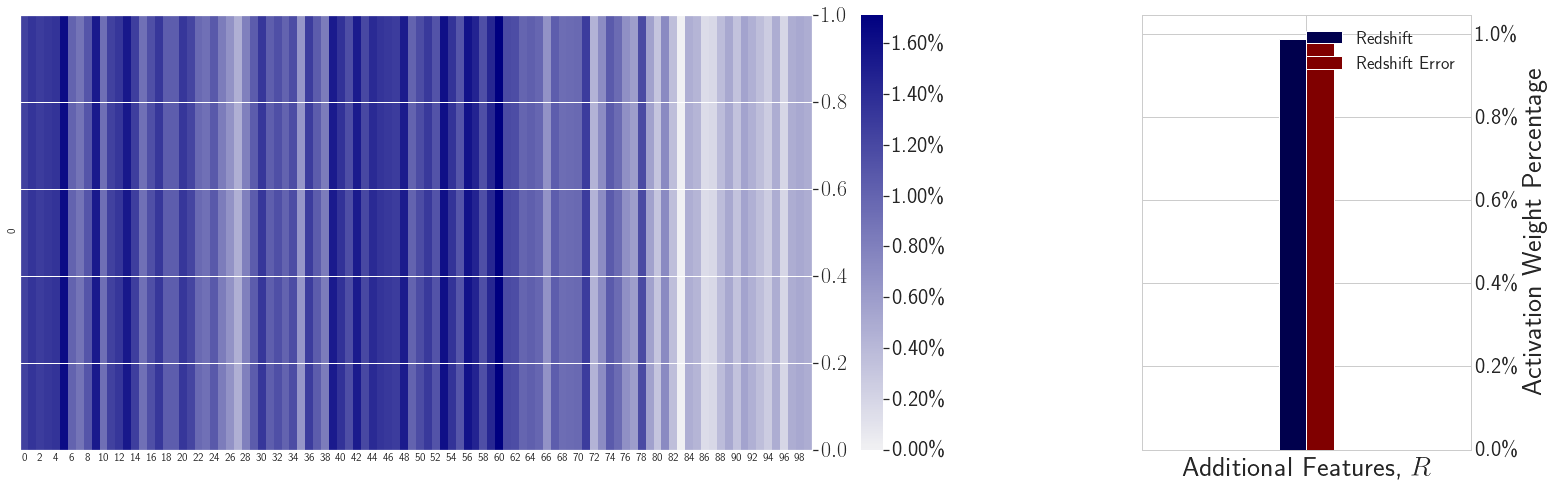

In [18]:
# Attempt to show 40 examples of SNIa
np.random.seed(RANDOM_SEED)
show_maps(desired_class=class_names.index("SNII"), num_maps=2)

# Make CAMs for all classes with x num_maps attempts
# make_cams(40)
